# Assignment 1 for FIT5212, TP5 2021

**Student Name:**  Sadia Karim

**Student ID:**    23386320

In [91]:
%%shell
jupyter nbconvert --to html '/content/code_23386320.ipynb'

[NbConvertApp] Converting notebook /content/code_23386320.ipynb to html
[NbConvertApp] Writing 3352925 bytes to /content/code_23386320.html


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


> # Part 1:  Text Classification

#### Algorithms
The 3 algorithms that I will use are:
1. Logistic Regression
2. Random Forest
3. RNN

#### Text Preprocessing
1. Removing Stopwords
2. Keeping Stopwords


> ## Installations

In [2]:
!pip install 'tune-sklearn' 'ray[tune]' 'pyLDAvis==2.1.2' 'scipy==1.7.1'

     |████████████████████████████████| 40 kB 3.3 MB/s 
     |████████████████████████████████| 49.6 MB 6.4 kB/s 
     |████████████████████████████████| 1.6 MB 49.0 MB/s 
     |████████████████████████████████| 28.5 MB 84 kB/s 
     |████████████████████████████████| 72 kB 490 kB/s 
     |████████████████████████████████| 124 kB 30.0 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97738 sha256=52bbc8b2122ea4a38827fdce9aabc555cdff5352063861b8930a72e1bb85779f
  Stored in directory: /root/.cache/pip/wheels/3b/fb/41/e32e5312da9f440d34c4eff0d2207b46dc9332a7b931ef1e89
Successfully built pyLDAvis
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2

In [3]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [4]:
#  import libraries and packages
import warnings
from nltk import word_tokenize   
from nltk.stem import WordNetLemmatizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV

from sklearn.metrics import classification_report, auc, average_precision_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import plot_precision_recall_curve, precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix


from sklearn.model_selection import GridSearchCV
from tune_sklearn import TuneSearchCV
import ray
from ray import tune

import gensim
from gensim.models import Word2Vec
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import re
import requests
import seaborn as sns
import string
import tensorflow as tf
import time
import torch
import torch.nn as nn
F = nn.functional

import torch.optim as toptim
from torchtext.legacy import data

import string
# more comprehensive list of stopwords built upon the nltk stopword list.
stopwords_list = requests.get("https://gist.githubusercontent.com/rg089/35e00abf8941d72d419224cfd5b5925d/raw/12d899b70156fd0041fa9778d657330b024b959c/stopwords.txt").content
stopwords = set(stopwords_list.decode().splitlines()) 

import pyLDAvis.gensim
pyLDAvis.enable_notebook()
from wordcloud import WordCloud
from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim.models import LdaModel

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
# Load the dataset into a pandas dataframe
df_train = pd.read_csv("/content/drive/MyDrive/FIT5212 A1/clickbait_train.csv")

# subset the first 1000 entries for the small dataset
df_train_small = df_train[0:1000]

# load full test data
df_test = pd.read_csv("/content/drive/MyDrive/FIT5212 A1/clickbait_test.csv")

In [6]:
def displayResults(test_label, preds):
    precision, recall, fscore, support = score(test_label, preds, average='macro')
    return print(
        f"Precision: {precision:.4f}\nRecall: {recall:.4f}\nF1-Score: {fscore:.4f}"
    )

def plotPrecRec(clf, test_data, test_label, title=''):
    disp = plot_precision_recall_curve(clf, test_data, test_label) 
    disp.ax_.set_title(f"{title} Precision-Recall curve")     

matplotlib.rc('figure', figsize=(10, 5)) # set plot sizes
plt.rcParams.update({'font.size': 16}) # set font size


---

I will generate my word vectors with the following:

* TfidfVectorizer - performed better than "CountVectorizer with MaxAbsScaler transformation"
* Keeping/Removing stopwords
* Keepinh text case - most clickbait articles have Title case althroughout the header, but non-clickbait tends to have lowercase
* Using WordNet lemmatizer - performed better than SpaCy
* Generating unigrams and bigrams - performed better than just unigrams, and trigrams

My two versions of text preprocessing are:

1. Keeping stopwords
2. Removing stopwords

## Prepare Text

PreProcessing includes:
* Keeping/Removing stopwords
* Keeping text case
* Tokenizing with WordNetLemmatizer 
* Generating unigrams and bigrams


In [5]:
# initialise wordnet lemmatizer
wnl=WordNetLemmatizer()

# method to convert words to tokens in both stem and lemma format
def tokenizer(text, method=None):
    tokens = []
    for t in text:
        words = word_tokenize(t)

        if method == 'stop':
          # we want to keep the original text case, so no changing to lowercase
            token = [wnl.lemmatize(w) for w in words] 
            # token = [token.translate(str.maketrans("", "", string.punctuation))]
        
        if method == 'nostop': 
            # since the stopword list is in lowercase, check the lowercase version of the word against the stopword list
            # but maintin the text's original case
            token = [wnl.lemmatize(w) for w in words if w.lower() not in stopwords] 
        
        tokens.append(token)
    return tokens      

In [8]:
nostopTrainSmall = tokenizer(df_train_small['text'], 'nostop')
nostopTrain = tokenizer(df_train['text'], 'nostop')
nostopTest = tokenizer(df_test['text'], 'nostop')

stopTrainSmall = tokenizer(df_train_small['text'], 'stop')
stopTrain = tokenizer(df_train['text'], 'stop')
stopTest = tokenizer(df_test['text'], 'stop')

train_label_small = df_train_small['class'] # get small training dataset classes
train_label_full = df_train['class']

test_label = df_test['class'] # get testing data classes

> ## TF-IDF Vectorize

TF-IDF Vectorize small nostopwords text

In [9]:
# Define TF-IDF vectorizer
tfidfVec = TfidfVectorizer(
    analyzer = 'word',
    input = 'content',
    lowercase = False,
    min_df = 3,
    ngram_range = (1,2),
    tokenizer = lambda x: x) # data is already tokenized, don't tokenize again

nostop_train_small = tfidfVec.fit_transform(nostopTrainSmall) # create vocab on lemma training data
nostop_test_small = tfidfVec.transform(nostopTest) # create vectors on lemma testing data

TF-IDF Vectorize on full nostopwords text

In [10]:
# Define TF-IDF vectorizer
tfidfVec = TfidfVectorizer(
    analyzer = 'word',
    input = 'content',
    lowercase = False,
    min_df = 3,
    ngram_range = (1,2),
    tokenizer = lambda x: x) # data is already tokenized, don't tokenize again

nostop_train_full = tfidfVec.fit_transform(nostopTrain) # create vocab on lemma training data
nostop_test_full = tfidfVec.transform(nostopTest) # create vectors on lemma testing data

TF-IDF Vectorize on small stopwords text

In [11]:
# Define TF-IDF vectorizer
tfidfVec = TfidfVectorizer(
    analyzer = 'word',
    input = 'content',
    lowercase = False,
    min_df = 3,
    ngram_range = (1,2),
    tokenizer = lambda x: x) # data is already tokenized, don't tokenize again

stop_train_small = tfidfVec.fit_transform(stopTrainSmall) # create vocab on stem data
stop_test_small = tfidfVec.transform(stopTest) # create vectors on stem testing data

TF-IDF Vectorize on full stopwords text

In [12]:
# Define TF-IDF vectorizer
tfidfVec = TfidfVectorizer(
    analyzer = 'word',
    input = 'content',
    lowercase = False,
    min_df = 3,
    ngram_range = (1,2),
    tokenizer = lambda x: x) # data is already tokenized, don't tokenize again

stop_train_full = tfidfVec.fit_transform(stopTrain) # create vocab on stem data
stop_test_full = tfidfVec.transform(stopTest) # create vectors on stem testing data

---
> # 1. Logistic Regression CV
LogisticRegressionCV automatically hypertunes the parameters through 10-fold cross validation


>## 1.1 LogRegCV + NoStopwords + Small

In [ ]:
# Logistic Regression with Cross Validation
# function will automatically apply 10-fold cross validation to find the best hyperparameters
nostopLogRegCVSmall = LogisticRegressionCV(cv=10, max_iter=500)

# classifier learns the training data
nostopLogRegCVSmall.fit(nostop_train_small, train_label_small)

# make predictions on test set vectorized by small dataset
logreg_nostop_small_preds = nostopLogRegCVSmall.predict(nostop_test_small)

# evaluate
displayResults(test_label, logreg_nostop_small_preds)
print('-----')
print('Confusion Matrix:\n', confusion_matrix(test_label, logreg_nostop_small_preds))

Precision: 0.8712
Recall: 0.8686
F1-Score: 0.8672
-----
Confusion Matrix:
 [[2302  199]
 [ 480 2139]]


> ## 1.2 LogRegCV + NoStopwords + Full

Precision: 0.9589
Recall: 0.9591
F1-Score: 0.9590
-----
Confusion Matrix:



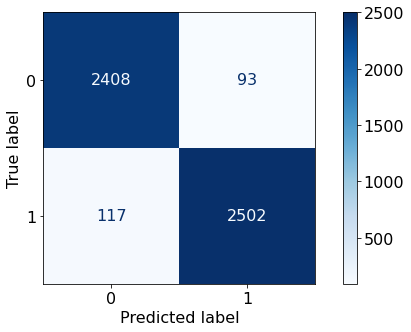

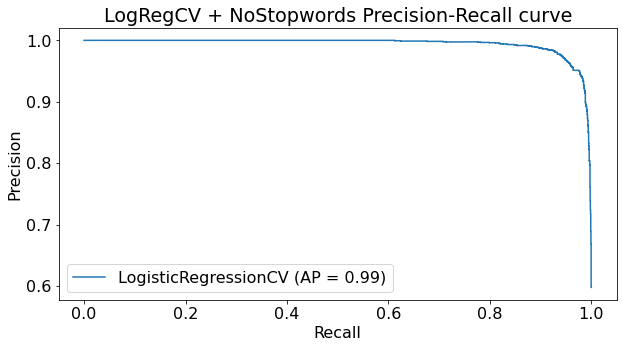

In [ ]:
# Logistic Regression with Cross Validation
# function will automatically apply 10-fold cross validation to find the best hyperparameters
nostopLogRegCV = LogisticRegressionCV(cv=10, max_iter=700)

# classifier learns the training data
nostopLogRegCV.fit(nostop_train_full, train_label_full)

# make predictions on test set vectorized by small dataset
logreg_nostop_full_preds = nostopLogRegCV.predict(nostop_test_full)

# evaluate
displayResults(test_label, logreg_nostop_full_preds)
print('-----')
print('Confusion Matrix:\n')
plot_confusion_matrix(nostopLogRegCV, nostop_test_full, test_label, cmap=plt.cm.Blues, values_format = '.5g')
plotPrecRec(nostopLogRegCV, nostop_test_full, test_label, 'LogRegCV + NoStopwords')

> ## 1.3 LogRegCV + Stopwords + Small

In [ ]:
# Logistic Regression with Cross Validation
# function will automatically apply 10-fold cross validation to find the best hyperparameters
stopLogRegCVSmall = LogisticRegressionCV(cv=10, max_iter=500)

# classifier learns the training data
stopLogRegCVSmall.fit(stop_train_small, train_label_small)

# make predictions on test set vectorized by small dataset
logreg_stop_small_preds = stopLogRegCVSmall.predict(stop_test_small)

# evaluate
displayResults(test_label, logreg_stop_small_preds)
print('-----')
print('Confusion Matrix:\n', confusion_matrix(test_label, logreg_stop_small_preds))

Precision: 0.9779
Recall: 0.9780
F1-Score: 0.9779
-----
Confusion Matrix:
 [[2450   51]
 [  62 2557]]


> ## 1.4 LogRegCV + Stopwords + Full

Precision: 0.9930
Recall: 0.9930
F1-Score: 0.9930
-----
Confusion Matrix:



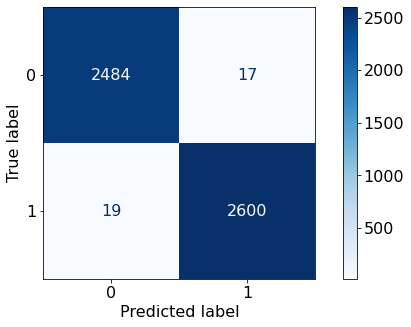

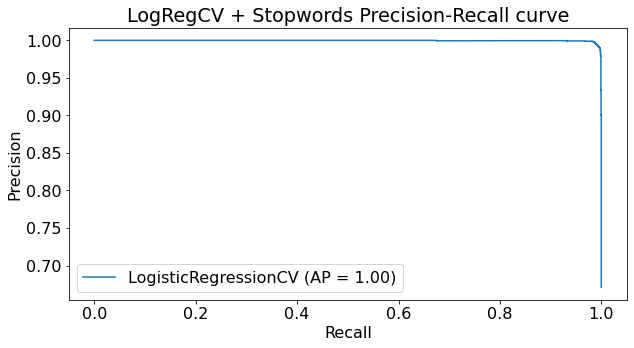

In [ ]:
# Logistic Regression with Cross Validation
# function will automatically apply 10-fold cross validation to find the best hyperparameters
stopLogRegCV = LogisticRegressionCV(cv=10, max_iter=500)

stopLogRegCV.fit(stop_train_full, train_label_full)

# make predictions on test set vectorized by small test data
logreg_stop_preds = stopLogRegCV.predict(stop_test_full)

# evaluate
displayResults(test_label, logreg_stop_preds)
print('-----')
print('Confusion Matrix:\n')
plot_confusion_matrix(stopLogRegCV, stop_test_full, test_label, cmap=plt.cm.Blues, values_format = '.5g')
plotPrecRec(stopLogRegCV, stop_test_full, test_label, 'LogRegCV + Stopwords')

---
#2. Random Forest Classifier

Using TuneSearchCV with 10-fold cross validation to find the best hyperparameters for each dataset.

In [ ]:
# Random Forest Classifier
rfc = RandomForestClassifier(random_state=1234)

############
# The following parameters will be used for hyptertuning all variations of the model:
############

# Number of features to consider at every split
max_features = ['sqrt', 'log2', None]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Warm start
warm_start = [True, False]

# Create the random grid
rfc_grid = {
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap,
    'warm_start': warm_start}

> ## 2.1 RFC + NoStopwords + Small

In [ ]:
nostopRfcCVSmall = TuneSearchCV(estimator = rfc, 
                          param_distributions = rfc_grid,
                          cv = 10, 
                          use_gpu = True, 
                          early_stopping = True,
                          max_iters = 10,
                          verbose = 1)

In [ ]:
nostopRfcCVSmall.fit(nostop_train_small, train_label_small)

TuneSearchCV(cv=10,
             early_stopping=<ray.tune.schedulers.async_hyperband.AsyncHyperBandScheduler object at 0x7f0a1b7e7d90>,
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=No...
                                  'max_features': ['sqrt', 'log2', None],
                                  'min_samples_leaf': [1, 2, 4],
                                  'min_samples_split': [2, 5, 10],
                                  'warm_start': [True, False]},


In [ ]:
nostopRfcCVSmall.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=100, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=1234,
                       verbose=0, warm_start=False)

In [ ]:
# get the best estimator
nostopRFCSmall = nostopRfcCVSmall.best_estimator_

# make predictions on test set vectorized by small dataset
rfc_nostop_small_preds = nostopRFCSmall.predict(nostop_test_small)

# evaluate
displayResults(test_label, rfc_nostop_small_preds)
print('-----')
print('Confusion Matrix:\n', confusion_matrix(test_label, rfc_nostop_small_preds))

Precision: 0.8330
Recall: 0.8197
F1-Score: 0.8157
-----
Confusion Matrix:
 [[2320  181]
 [ 755 1864]]


> ## 2.2 RFC + NoStopwords + Full

In [ ]:
nostopRfcCV = TuneSearchCV(estimator = rfc, 
                          param_distributions = rfc_grid,
                          cv = 10, 
                          use_gpu = True, 
                          early_stopping = True,
                          max_iters = 10,
                          verbose = 1)

In [ ]:
nostopRfcCV.fit(nostop_train_full, train_label_full)

TuneSearchCV(cv=10,
             early_stopping=<ray.tune.schedulers.async_hyperband.AsyncHyperBandScheduler object at 0x7f0a1b681a10>,
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=No...
                                  'max_features': ['sqrt', 'log2', None],
                                  'min_samples_leaf': [1, 2, 4],
                                  'min_samples_split': [2, 5, 10],
                                  'warm_start': [True, False]},


In [ ]:
nostopRfcCV.best_estimator_

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=110, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=1234,
                       verbose=0, warm_start=False)

RFC + NoStopwords

Precision: 0.9203
Recall: 0.9153
F1-Score: 0.9160
-----
Confusion Matrix:



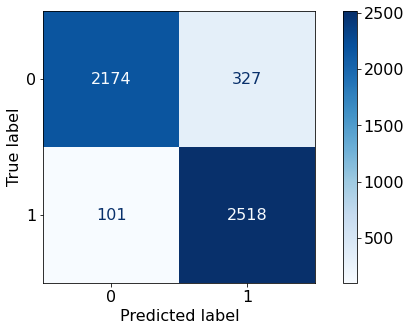

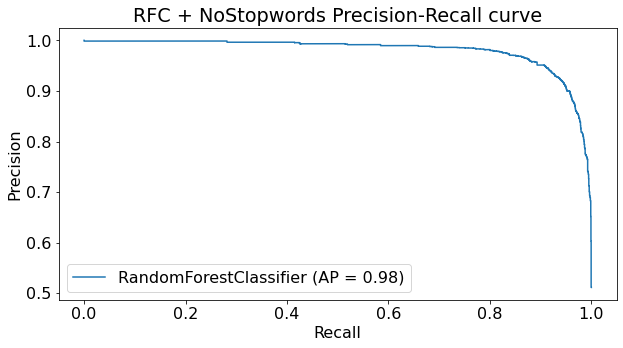

In [89]:
# get the best estimator
nostopRFC = nostopRfcCV.best_estimator_

# make predictions on test set
rfc_nostop_preds = nostopRFC.predict(nostop_test_full)

# evaluate
print('RFC + NoStopwords\n')
displayResults(test_label, rfc_nostop_preds)
print('-----')
print('Confusion Matrix:\n')
plot_confusion_matrix(nostopRFC, nostop_test_full, test_label, cmap=plt.cm.Blues, values_format = '.5g')
plotPrecRec(nostopRFC, nostop_test_full, test_label, title='RFC + NoStopwords')

> ## 2.3 RFC + Stopwords + Small

In [ ]:
stopRfcCVSmall = TuneSearchCV(estimator = rfc, 
                          param_distributions = rfc_grid,
                          cv = 10, 
                          use_gpu = True, 
                          early_stopping = True,
                          max_iters = 10,
                          verbose = 1)

In [ ]:
stopRfcCVSmall.fit(stop_train_small, train_label_small)

TuneSearchCV(cv=10,
             early_stopping=<ray.tune.schedulers.async_hyperband.AsyncHyperBandScheduler object at 0x7f0a1b793890>,
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=No...
                                  'max_features': ['sqrt', 'log2', None],
                                  'min_samples_leaf': [1, 2, 4],
                                  'min_samples_split': [2, 5, 10],
                                  'warm_start': [True, False]},


In [ ]:
stopRfcCVSmall.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=70, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=1234,
                       verbose=0, warm_start=False)

In [ ]:
# get the best estimator
stopRFCSmall = stopRfcCVSmall.best_estimator_

# make predictions on test set vectorized by small dataset
rfc_stop_small_preds = stopRFCSmall.predict(stop_test_small)

# evaluate
displayResults(test_label, rfc_stop_small_preds)
print('-----')
print('Confusion Matrix:\n', confusion_matrix(test_label, rfc_stop_small_preds))

Precision: 0.9371
Recall: 0.9362
F1-Score: 0.9353
-----
Confusion Matrix:
 [[2430   71]
 [ 260 2359]]


> ## 2.4 RFC + Stopwords + Full

In [ ]:
stopRfcCV = TuneSearchCV(estimator=rfc, 
                          param_distributions=rfc_grid,
                          cv=10, 
                          use_gpu= True, 
                          early_stopping=True,
                          max_iters = 10,
                          verbose=1)

In [ ]:
stopRfcCV.fit(stop_train_full, train_label_full)

TuneSearchCV(cv=10,
             early_stopping=<ray.tune.schedulers.async_hyperband.AsyncHyperBandScheduler object at 0x7f0a1b9d1690>,
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=No...
                                  'max_features': ['sqrt', 'log2', None],
                                  'min_samples_leaf': [1, 2, 4],
                                  'min_samples_split': [2, 5, 10],
                                  'warm_start': [True, False]},


In [ ]:
stopRfcCV.best_estimator_

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=1234,
                       verbose=0, warm_start=False)

RFC + Stopwords

Precision: 0.9812
Recall: 0.9812
F1-Score: 0.9812
-----
Confusion Matrix:



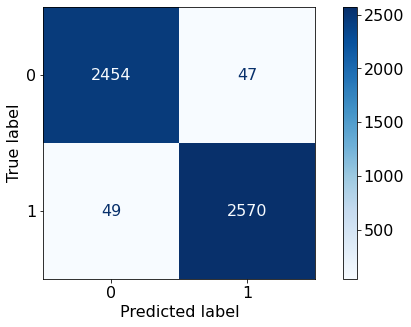

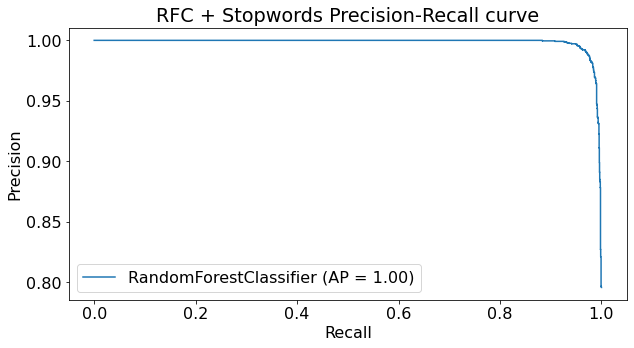

In [ ]:
# get best estimator
stopRFC = stopRfcCV.best_estimator_

# make predictions on test set
rfc_stop_preds = stopRFC.predict(stop_test_full)

# evaluate
print('RFC + Stopwords\n')
displayResults(test_label, rfc_stop_preds)
print('-----')
print('Confusion Matrix:\n')
plot_confusion_matrix(stopRFC, stop_test_full, test_label, cmap=plt.cm.Blues, values_format = '.5g')
plotPrecRec(stopRFC, stop_test_full, test_label, title='RFC + Stopwords')



---
# 3. Recurrent Neural Network


> ## Data Preparation

In [13]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [14]:
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [15]:
def plot_static_precision_recall_curve(recall, precision, title, ap):
    pl = plt.plot(recall, precision, label=('AP = %0.2f' % ap))
    plt.ylabel("Precision")
    plt.xlabel("Recall")
    plt.legend(pl, ['RecurrentNeuralNetwork (AP = %0.2f)' % ap])
    plt.title(f"{title} Precision-Recall curve");

In [16]:
def getResults(model, testdata):
    y_prob = []
    y_predict = []
    y_test = []

    model.eval()
    with torch.no_grad():
        for batch in testdata:
            text = batch.text.to(device)
            label = batch.label.to(device)

            predictions = model(text).squeeze(1)
            pred_val = torch.sigmoid(predictions).to('cpu')
            y_prob += pred_val
            y_predict += torch.round(pred_val).tolist()
            y_test += batch.label.tolist()

        y_prob = np.asarray(y_prob)
        y_predict = np.asarray(y_predict)
        y_test = np.asarray(y_test)

        # Find precision & recall for thresholds
        prec, rec, thresholds = precision_recall_curve(y_test, y_prob)
        ap = auc(rec, prec)

        return {'prec':prec, 'rec':rec, 'ap': ap, 'y_predict': y_predict, 'y_test': y_test}

In [17]:
class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim):
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        
        self.rnn = nn.RNN(embedding_dim, hidden_dim)
        
        self.fc = nn.Linear(hidden_dim, 1)
        
    def forward(self, text):

        #text = [sent len, batch size]
        
        embedded = self.embedding(text)
        
        #embedded = [sent len, batch size, emb dim]
        
        output, hidden = self.rnn(embedded)
        
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        
        assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        
        return self.fc(hidden.squeeze(0))

In [18]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        text = batch.text.to(device)
        label = batch.label.to(device)

        optimizer.zero_grad()
                
        predictions = model(text).squeeze(1)
        
        loss = criterion(predictions, label)
        
        acc = binary_accuracy(predictions, label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [19]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:
            text = batch.text.to(device)
            label = batch.label.to(device)

            predictions = model(text).squeeze(1)
            
            loss = criterion(predictions, label)
            
            acc = binary_accuracy(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [20]:
# create dataframes of lemmatized text and class labels to be fed to the buildIterator function
df_nostopTrainSmall = pd.DataFrame({'text': nostopTrainSmall, 'class': train_label_small})

df_nostopTrain = pd.DataFrame({'text': nostopTrain, 'class': train_label_full})

df_nostopTest = pd.DataFrame({'text': nostopTest, 'class': test_label})

df_stopTrainSmall = pd.DataFrame({'text': stopTrainSmall, 'class': train_label_small})

df_stopTrain = pd.DataFrame({'text': stopTrain, 'class': train_label_full})

df_stopTest = pd.DataFrame({'text': stopTest, 'class': test_label})

In [21]:
# function to create an iterator from a dataframe
def buildIterator(traindf, testdf):
  
    TEXT = data.Field(sequential=True, tokenize=None, lower=False) # define text field properties
    LABEL = data.LabelField(dtype = torch.float, use_vocab=False, preprocessing=int) # define label properties
    datafields = [("text",TEXT),("label",LABEL)]

    # loop through the train dataframe values and create an Example object
    df_train_examples = [data.Example.fromlist(i, datafields) for i in traindf.values.tolist()]
    # create a dataset from the Example object with data properties as defined by datafields
    dftrain = data.Dataset(df_train_examples, datafields)

    df_test_examples = [data.Example.fromlist(i, datafields) for i in testdf.values.tolist()]
    # create a dataset from the Example object with data properties as defined by datafields
    test = data.Dataset(df_test_examples, datafields)

    # build vocabulary from the text
    TEXT.build_vocab(dftrain)
    # return the length of the vocab to be used as a parameter to our RNN function
    vocab = TEXT.vocab
    vocab_size = len(vocab)

    train, validate = dftrain.split(split_ratio=0.8)

    dl_train, dl_valid, dl_test = data.BucketIterator.splits(
    (train, validate, test), 
    batch_size = batch_size,
    device = device,
    sort_key = lambda x: len(x.text),
    sort_within_batch = True)
    return {'dl_train': dl_train, 'dl_valid': dl_valid, 'dl_test': dl_test, 'vocab_size': vocab_size}

In [22]:
batch_size = 32

# build data iterators
nostop_small = buildIterator(df_nostopTrainSmall, df_nostopTest)
nostop_full = buildIterator(df_nostopTrain, df_nostopTest)

stop_small = buildIterator(df_stopTrainSmall, df_stopTest)
stop_full = buildIterator(df_stopTrain, df_stopTest)

In [23]:
criterion = nn.BCEWithLogitsLoss()

> ## 3.1 RNN + NoStopwords + Small

In [33]:
SEED = 0

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [34]:
INPUT_DIM = nostop_small['vocab_size'] 
EMBEDDING_DIM = 60
HIDDEN_DIM = 30

nostopSmallRNN = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM).to(device)
optimizer = toptim.Adam(nostopSmallRNN.parameters(), lr=0.001)
criterion = criterion.to(device)

In [76]:
N_EPOCHS = 15

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(nostopSmallRNN, nostop_small['dl_train'], optimizer, criterion)
    valid_loss, valid_acc = evaluate(nostopSmallRNN, nostop_small['dl_valid'], criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(nostopSmallRNN.state_dict(), 'RNN_model.pt')

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.310 | Train Acc: 88.88%
	 Val. Loss: 0.535 |  Val. Acc: 76.79%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.308 | Train Acc: 88.88%
	 Val. Loss: 0.535 |  Val. Acc: 76.79%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.309 | Train Acc: 88.88%
	 Val. Loss: 0.535 |  Val. Acc: 76.79%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.307 | Train Acc: 88.88%
	 Val. Loss: 0.535 |  Val. Acc: 76.79%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.306 | Train Acc: 89.25%
	 Val. Loss: 0.535 |  Val. Acc: 76.79%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.309 | Train Acc: 89.12%
	 Val. Loss: 0.535 |  Val. Acc: 76.79%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.306 | Train Acc: 89.00%
	 Val. Loss: 0.535 |  Val. Acc: 76.79%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.311 | Train Acc: 89.25%
	 Val. Loss: 0.535 |  Val. Acc: 76.79%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.301 | Train Acc: 89.88%
	 Val. Loss: 0.535 |  Val. Acc: 76.79%
Epoch: 10 | Epoch Time: 0m 0

In [77]:
nostopSmallRNN.load_state_dict(torch.load('RNN_model.pt'))

test_loss, test_acc = evaluate(nostopSmallRNN, nostop_small['dl_test'], criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.525 | Test Acc: 74.75%


In [78]:
nostopRNNSmallResults = getResults(nostopSmallRNN, nostop_small['dl_test'])

displayResults(nostopRNNSmallResults['y_test'], nostopRNNSmallResults['y_predict'])
print('-----')
print('Confusion Matrix:\n', confusion_matrix(nostopRNNSmallResults['y_test'], nostopRNNSmallResults['y_predict']))

Precision: 0.7919
Recall: 0.7519
F1-Score: 0.7396
-----
Confusion Matrix:
 [[2359  142]
 [1151 1468]]


> ## 3.2 RNN + NoStopwords + Full

In [38]:
INPUT_DIM = nostop_full['vocab_size']
EMBEDDING_DIM = 60
HIDDEN_DIM = 30

nostopFullRNN = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM).to(device)
optimizer = toptim.Adam(nostopFullRNN.parameters(), lr=0.001)
criterion = criterion.to(device)

In [39]:
N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(nostopFullRNN, nostop_full['dl_train'], optimizer, criterion)
    valid_loss, valid_acc = evaluate(nostopFullRNN, nostop_full['dl_valid'], criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(nostopFullRNN.state_dict(), 'RNN_model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 2s
	Train Loss: 0.516 | Train Acc: 72.61%
	 Val. Loss: 0.326 |  Val. Acc: 86.96%
Epoch: 02 | Epoch Time: 0m 2s
	Train Loss: 0.263 | Train Acc: 89.44%
	 Val. Loss: 0.225 |  Val. Acc: 91.11%
Epoch: 03 | Epoch Time: 0m 2s
	Train Loss: 0.157 | Train Acc: 94.24%
	 Val. Loss: 0.186 |  Val. Acc: 92.58%
Epoch: 04 | Epoch Time: 0m 2s
	Train Loss: 0.098 | Train Acc: 96.60%
	 Val. Loss: 0.182 |  Val. Acc: 93.26%
Epoch: 05 | Epoch Time: 0m 2s
	Train Loss: 0.065 | Train Acc: 97.78%
	 Val. Loss: 0.193 |  Val. Acc: 93.26%
Epoch: 06 | Epoch Time: 0m 2s
	Train Loss: 0.038 | Train Acc: 98.86%
	 Val. Loss: 0.201 |  Val. Acc: 93.51%
Epoch: 07 | Epoch Time: 0m 2s
	Train Loss: 0.022 | Train Acc: 99.41%
	 Val. Loss: 0.232 |  Val. Acc: 93.48%
Epoch: 08 | Epoch Time: 0m 2s
	Train Loss: 0.013 | Train Acc: 99.66%
	 Val. Loss: 0.232 |  Val. Acc: 93.65%
Epoch: 09 | Epoch Time: 0m 2s
	Train Loss: 0.008 | Train Acc: 99.83%
	 Val. Loss: 0.267 |  Val. Acc: 93.51%
Epoch: 10 | Epoch Time: 0m 2

In [40]:
nostopFullRNN.load_state_dict(torch.load('RNN_model.pt'))

test_loss, test_acc = evaluate(nostopFullRNN, nostop_full['dl_test'], criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.213 | Test Acc: 92.50%


RNN + NoStopwords
Precision: 0.9269
Recall: 0.9259
F1-Score: 0.9250
-----
Confusion Matrix:



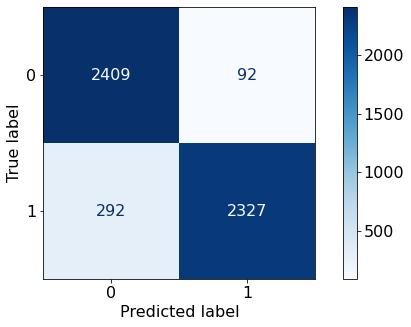

In [44]:
nostopRNNFullResults = getResults(nostopFullRNN, nostop_full['dl_test'])

print('RNN + NoStopwords')
displayResults(nostopRNNFullResults['y_test'], nostopRNNFullResults['y_predict'])
print('-----')
print('Confusion Matrix:\n')
ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(nostopRNNFullResults['y_test'], nostopRNNFullResults['y_predict']), 
    display_labels=[0,1]
    ).plot(cmap=plt.cm.Blues, values_format = '.5g')

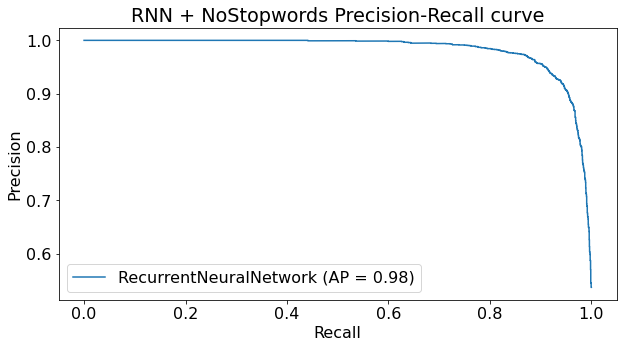

In [72]:
plot_static_precision_recall_curve(nostopRNNFullResults['rec'], 
                                   nostopRNNFullResults['prec'], 
                                   title='RNN + NoStopwords', 
                                   ap=nostopRNNFullResults['ap'])

> ## 3.3 RNN + Stopwords + Small

In [73]:
INPUT_DIM = stop_small['vocab_size']
EMBEDDING_DIM = 60
HIDDEN_DIM = 30

stopRNNSmall = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM).to(device)
optimizer = toptim.Adam(stopRNNSmall.parameters(), lr=0.001)
criterion = criterion.to(device)

In [74]:
N_EPOCHS = 15

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(stopRNNSmall, stop_small['dl_train'], optimizer, criterion)
    valid_loss, valid_acc = evaluate(stopRNNSmall, stop_small['dl_valid'], criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(stopRNNSmall.state_dict(), 'RNN_model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.703 | Train Acc: 48.62%
	 Val. Loss: 0.690 |  Val. Acc: 53.12%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.670 | Train Acc: 57.50%
	 Val. Loss: 0.677 |  Val. Acc: 58.48%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.648 | Train Acc: 62.00%
	 Val. Loss: 0.657 |  Val. Acc: 66.07%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.596 | Train Acc: 70.75%
	 Val. Loss: 0.614 |  Val. Acc: 63.39%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.490 | Train Acc: 81.00%
	 Val. Loss: 0.455 |  Val. Acc: 81.25%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.332 | Train Acc: 87.88%
	 Val. Loss: 0.342 |  Val. Acc: 86.16%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.219 | Train Acc: 92.88%
	 Val. Loss: 0.275 |  Val. Acc: 90.18%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.156 | Train Acc: 96.12%
	 Val. Loss: 0.256 |  Val. Acc: 90.62%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.103 | Train Acc: 98.00%
	 Val. Loss: 0.248 |  Val. Acc: 91.52%
Epoch: 10 | Epoch Time: 0m 0

In [75]:
stopRNNSmall.load_state_dict(torch.load('RNN_model.pt'))

test_loss, test_acc = evaluate(stopRNNSmall, stop_small['dl_test'], criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.208 | Test Acc: 92.75%


In [79]:
stopRNNSmallResults = getResults(stopRNNSmall, stop_small['dl_test'])

displayResults(stopRNNSmallResults['y_test'], stopRNNSmallResults['y_predict'])
print('-----')
print('Confusion Matrix:\n', confusion_matrix(stopRNNSmallResults['y_test'], stopRNNSmallResults['y_predict']))

Precision: 0.9283
Recall: 0.9285
F1-Score: 0.9283
-----
Confusion Matrix:
 [[2342  159]
 [ 208 2411]]


> ## 3.4 RNN + Stopwords + Full

In [80]:
INPUT_DIM = stop_full['vocab_size']
EMBEDDING_DIM = 60
HIDDEN_DIM = 30

stopRNNFull = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM).to(device)
optimizer = toptim.Adam(stopRNNFull.parameters(), lr=0.001)
criterion = criterion.to(device)

In [81]:
N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(stopRNNFull, stop_full['dl_train'], optimizer, criterion)
    valid_loss, valid_acc = evaluate(stopRNNFull, stop_full['dl_valid'], criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(stopRNNFull.state_dict(), 'RNN_model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 2s
	Train Loss: 0.280 | Train Acc: 87.13%
	 Val. Loss: 0.120 |  Val. Acc: 95.95%
Epoch: 02 | Epoch Time: 0m 2s
	Train Loss: 0.072 | Train Acc: 97.50%
	 Val. Loss: 0.072 |  Val. Acc: 97.49%
Epoch: 03 | Epoch Time: 0m 2s
	Train Loss: 0.037 | Train Acc: 98.84%
	 Val. Loss: 0.064 |  Val. Acc: 97.75%
Epoch: 04 | Epoch Time: 0m 2s
	Train Loss: 0.024 | Train Acc: 99.30%
	 Val. Loss: 0.063 |  Val. Acc: 97.97%
Epoch: 05 | Epoch Time: 0m 2s
	Train Loss: 0.012 | Train Acc: 99.65%
	 Val. Loss: 0.062 |  Val. Acc: 97.97%
Epoch: 06 | Epoch Time: 0m 2s
	Train Loss: 0.008 | Train Acc: 99.81%
	 Val. Loss: 0.063 |  Val. Acc: 98.29%
Epoch: 07 | Epoch Time: 0m 2s
	Train Loss: 0.005 | Train Acc: 99.89%
	 Val. Loss: 0.058 |  Val. Acc: 98.24%
Epoch: 08 | Epoch Time: 0m 2s
	Train Loss: 0.004 | Train Acc: 99.91%
	 Val. Loss: 0.074 |  Val. Acc: 98.07%
Epoch: 09 | Epoch Time: 0m 2s
	Train Loss: 0.004 | Train Acc: 99.92%
	 Val. Loss: 0.087 |  Val. Acc: 98.10%
Epoch: 10 | Epoch Time: 0m 2

In [82]:
stopRNNFull.load_state_dict(torch.load('RNN_model.pt'))

test_loss, test_acc = evaluate(stopRNNFull, stop_full['dl_test'], criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.055 | Test Acc: 98.50%


RNN + Stopwords
Precision: 0.9849
Recall: 0.9850
F1-Score: 0.9850
-----
Confusion Matrix:



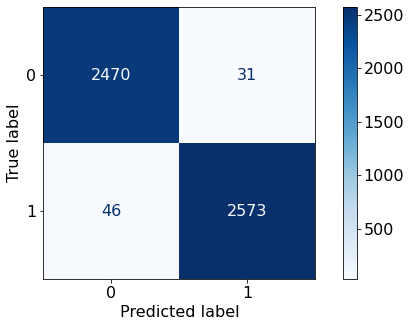

In [83]:
stopRNNFullResults = getResults(stopRNNFull, stop_full['dl_test'])

print('RNN + Stopwords')
displayResults(stopRNNFullResults['y_test'], stopRNNFullResults['y_predict'])
print('-----')
print('Confusion Matrix:\n')
ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(stopRNNFullResults['y_test'], stopRNNFullResults['y_predict']), 
    display_labels=[0,1]
    ).plot(cmap=plt.cm.Blues, values_format = '.5g')

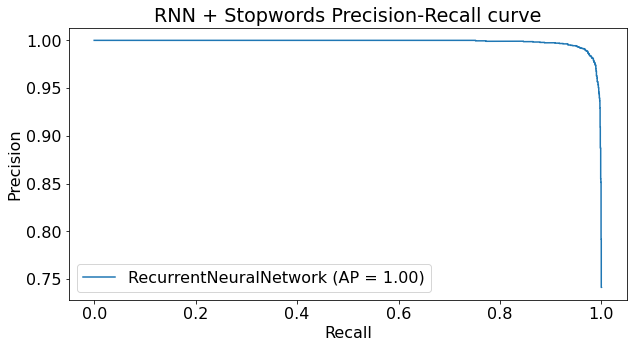

In [ ]:
plot_static_precision_recall_curve(stopRNNFullResults['rec'], 
                                   stopRNNFullResults['prec'], 
                                   title='RNN + Stopwords', 
                                   ap=stopRNNFullResults['ap'])

---

# Part 2:  Topic Modelling

#### Text Preprocessing
1. Remove stopwords
2. Keep stopwords

Because stopwords were so important in Part 1, I am interested to see how they affect topic modelling when they are removed

#### Topic numbers
1. 5
2. 15

> ## Data Exploration

First explore the raw text, and then lemmatize and remove stopwords to see the difference

In [ ]:
removeSet = []
for line in nostopTrain:
  for token in line:
    if all(i in string.punctuation for i in token):
      removeSet.append(token)

remSet = set(removeSet)

In [ ]:
remSet

{'!',
 '#',
 '$',
 '%',
 '&',
 "'",
 "''",
 '(',
 ')',
 '+',
 ',',
 '-',
 '--',
 '.',
 '...',
 '/',
 ':',
 ';',
 '=',
 '?',
 '@',
 '[',
 ']',
 '``',
 '|'}

In [ ]:
# function to compute coherence for a range of K numbers
from gensim.models import CoherenceModel
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """

    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model= gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                           num_topics=num_topics,  
                                           id2word=dictionary,
                                            )
        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

Build documents, dictionary and corpus for nostopTrain data

In [ ]:
# splits words with underscores into separate strings
nostopDocs = [[word for token in doc for word in token.split('_')] for doc in nostopTrain]

# Remove numbers, but not words that contain numbers.
nostopDocs = [[token for token in doc if not token.isnumeric()] for doc in nostopDocs]
# remove commas from middle of tokens (eg. 500,000 -> 500000)
nostopDocs = [[token.replace(',', '') for token in doc] for doc in nostopDocs]
# remove values if they are digits
nostopDocs = [[token for token in doc if not token.replace('.','',1).isdigit()] for doc in nostopDocs]

# Remove punctuation
nostopDocs = [[token for token in doc if token not in remSet] for doc in nostopDocs]
nostopDocs = [[token.strip(string.punctuation) for token in doc] for doc in nostopDocs]

# Remove words that are only one character.
nostopDocs = [[token for token in doc if len(token) > 2 and not token.islower()] for doc in nostopDocs]

# lowercase all words
nostopDocs = [[token.lower() for token in doc] for doc in nostopDocs]

In [ ]:
warnings.filterwarnings("ignore") # filter out deprecation warnings
# Add bigrams and trigrams to docs (only ones that appear 50 times or more).
nostopBigram = Phrases(nostopDocs, min_count=50)
for idx in range(len(nostopDocs)):
    for token in nostopBigram[nostopDocs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            nostopDocs[idx].append(token)

# Create a dictionary representation of the documents.
nostopDictionary = Dictionary(nostopDocs)

# Filter out words that occur less than 30 documents, or more than 50% of the documents.
nostopDictionary.filter_extremes(no_below=30, no_above=0.6)


nostopCorpus = [nostopDictionary.doc2bow(doc) for doc in nostopDocs]

print('Number of unique tokens: %d' % len(nostopDictionary))
print('Number of documents: %d' % len(nostopCorpus))

Number of unique tokens: 461
Number of documents: 20480


Plotting graph


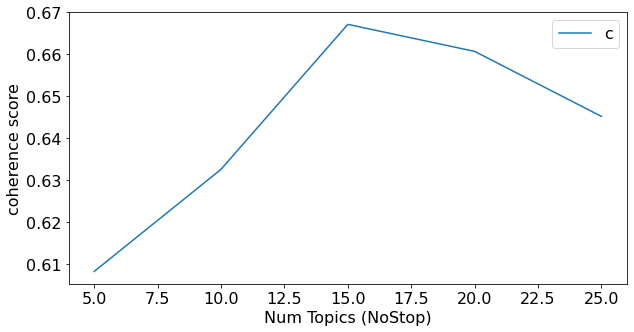

Num Topics = 5  has Coherence Value of 0.6082
Num Topics = 10  has Coherence Value of 0.6326
Num Topics = 15  has Coherence Value of 0.6672
Num Topics = 20  has Coherence Value of 0.6607
Num Topics = 25  has Coherence Value of 0.6452


In [ ]:
warnings.filterwarnings("ignore") # filter out deprecation warnings
start=5
limit=30
step=5
 

model_list, coherence_values = compute_coherence_values(dictionary=nostopDictionary, corpus=nostopCorpus, 
                                                        texts=nostopDocs, start=start, limit=limit, step=step)
# Print the coherence scores
print ('Plotting graph')
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics (NoStop)")
plt.ylabel("coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

for m, cv in zip(x, coherence_values):
    round_cv = round(cv, 4)
    print("Num Topics =", m, " has Coherence Value of", round_cv)

15 Topics yields the highest coherence score

Build documents, dictionary and corpus for stopTrain data

In [ ]:
# splits words with underscores into separate strings
stopDocs = [[word for token in doc for word in token.split('_')] for doc in stopTrain]

# Remove numbers, but not words that contain numbers.
stopDocs = [[token for token in doc if not token.isnumeric()] for doc in stopTrain]
# remove commas from middle of tokens (eg. 500,000 -> 500000)
stopDocs = [[token.replace(',', '') for token in doc] for doc in stopDocs]
# remove values if they are digits
stopDocs = [[token for token in doc if not token.replace('.','',1).isdigit()] for doc in stopDocs]

# Remove punctuation
stopDocs = [[token for token in doc if token not in remSet] for doc in stopDocs]
stopDocs = [[token.strip(string.punctuation) for token in doc] for doc in stopDocs]

# Remove words that are only one character.
stopDocs = [[token for token in doc if len(token) > 2 and not token.islower()] for doc in stopDocs]
# stopDocs = [[token for token in doc if len(token) > 1] for doc in stopDocs]

# lowercase all words
stopDocs = [[token.lower() for token in doc] for doc in stopDocs]

# Add bigrams and trigrams to docs (only ones that appear 30 times or more).
stopBigram = Phrases(stopDocs, min_count=50)
for idx in range(len(stopDocs)):
    for token in stopBigram[stopDocs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            stopDocs[idx].append(token)

In [ ]:
# Create a dictionary representation of the documents.
stopDictionary = Dictionary(stopDocs)

# Filter out words that occur less than 30 documents, or more than 50% of the documents.
stopDictionary.filter_extremes(no_below=30, no_above=0.6)


stopCorpus = [stopDictionary.doc2bow(doc) for doc in stopDocs]

print('Number of unique tokens: %d' % len(stopDictionary))
print('Number of documents: %d' % len(stopCorpus))

Number of unique tokens: 657
Number of documents: 20480


Plotting graph


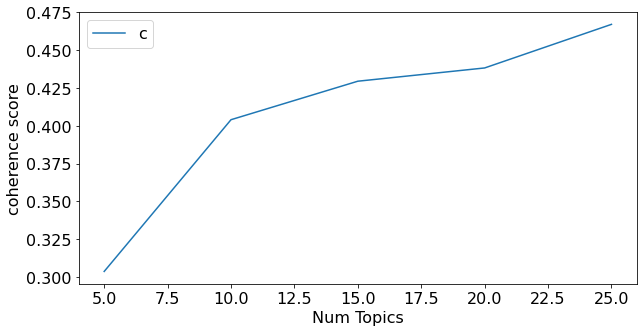

Num Topics = 5  has Coherence Value of 0.3037
Num Topics = 10  has Coherence Value of 0.404
Num Topics = 15  has Coherence Value of 0.4295
Num Topics = 20  has Coherence Value of 0.4383
Num Topics = 25  has Coherence Value of 0.4671


In [ ]:
warnings.filterwarnings("ignore") # filter out deprecation warnings
start=5
limit=30
step=5

model_list, coherence_values = compute_coherence_values(dictionary=stopDictionary, corpus=stopCorpus, 
                                                        texts=stopDocs, start=start, limit=limit, step=step)
# Print the coherence scores
print ('Plotting graph')
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

for m, cv in zip(x, coherence_values):
    round_cv = round(cv, 4)
    print("Num Topics =", m, " has Coherence Value of", round_cv)

25 topics yields the second highest coherence score

Total number of words: 82559
Unique words: 16674


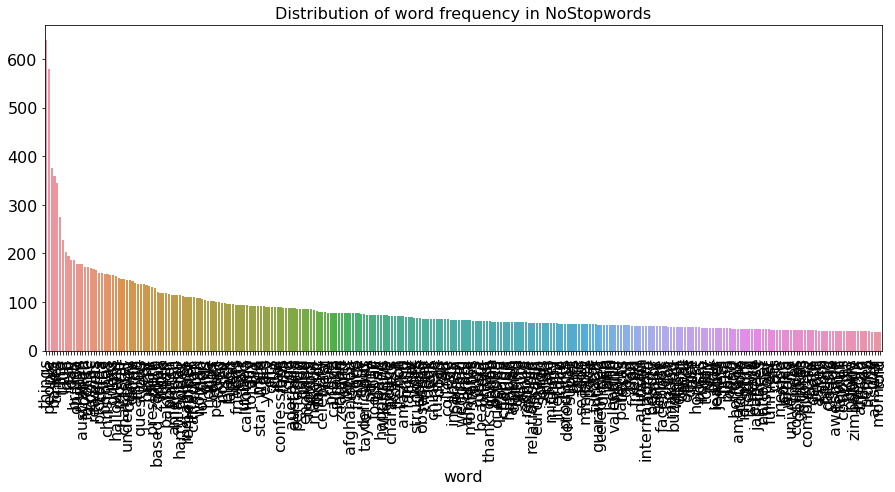

In [ ]:
from collections import Counter
flatten = lambda l : [item for sublist in l for item in sublist]
allword = flatten(nostopDocs)
print ('Total number of words:', len(allword))
print ('Unique words:', len(set(allword)))
word = 300
most_common = Counter(allword).most_common(word)
least_common = Counter(allword).most_common()[-word-1:-1]
x = [i[0] for i in most_common]
y = [i[1] for i in most_common]

fig, ax = plt.subplots(figsize=(15,6))
ax.set_title("Distribution of word frequency in NoStopwords", fontsize=16)
ax.set_xlabel("word")
plt.xticks(rotation=90)
sns.barplot(x,y)

Total number of words: 127144
Unique words: 17136


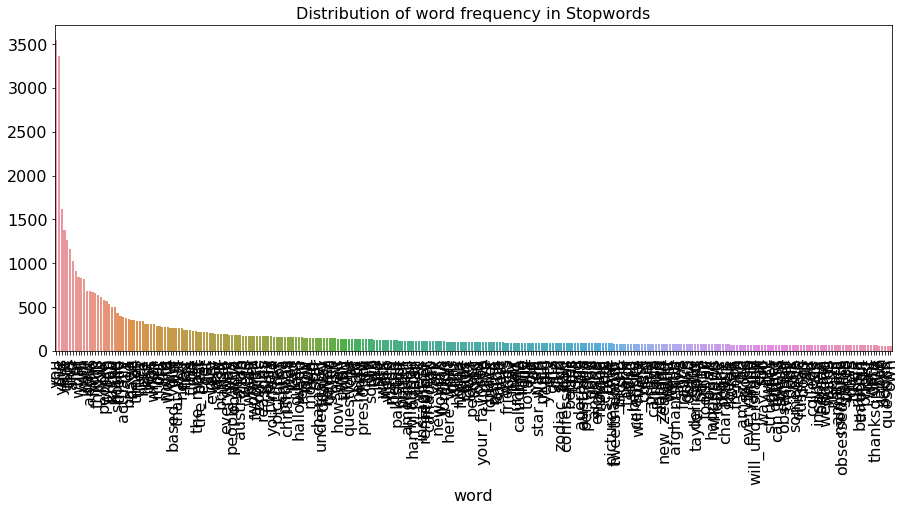

In [ ]:
flatten = lambda l : [item for sublist in l for item in sublist]
allword = flatten(stopDocs)
print ('Total number of words:', len(allword))
print ('Unique words:', len(set(allword)))
word = 300
most_common = Counter(allword).most_common(word)
least_common = Counter(allword).most_common()[-word-1:-1]
x = [i[0] for i in most_common]
y = [i[1] for i in most_common]

fig, ax = plt.subplots(figsize=(15,6))
ax.set_title("Distribution of word frequency in Stopwords", fontsize=16)
ax.set_xlabel("word")
plt.xticks(rotation=90)
sns.barplot(x,y)

> ## 2.1 No Stopwords, K=5

In [ ]:
# Train LDA model.
# Set training parameters.
NUM_TOPICS = 5
corpus = nostopCorpus
chunksize = 2000
passes = 20
iterations = 500
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = nostopDictionary[0]  # This is only to "load" the dictionary.
id2word = nostopDictionary.id2token

nostopModel5 = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=NUM_TOPICS,
    passes=passes,
    eval_every=eval_every
)
outputfile = f'model{NUM_TOPICS}.gensim'
print("Saving model in " + outputfile)
print("")
nostopModel5.save(outputfile)

Saving model in model5.gensim



In [ ]:
# Compute Perplexity - model with lowest perplexity is best
print('\nPerplexity: ', nostopModel5.log_perplexity(nostopCorpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score - the higher the coherence score, the better
coherence_model_lda = CoherenceModel(model=nostopModel5, texts=nostopDocs, dictionary=nostopDictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -5.983189175676986

Coherence Score:  0.59653846366891


In [ ]:
top_topics = nostopModel5.top_topics(corpus) #, num_words=20)
nostopModel5.num_topics

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / NUM_TOPICS
print('Average topic coherence: %.4f.' % avg_topic_coherence)

nostopModel5.print_topics( num_words=10)

Average topic coherence: -15.3373.


[(0,
  '0.033*"christmas" + 0.030*"day" + 0.028*"australian" + 0.027*"favorite" + 0.025*"china" + 0.025*"game" + 0.024*"pictures" + 0.022*"south" + 0.020*"test" + 0.019*"girls"'),
 (1,
  '0.062*"u.s" + 0.049*"based" + 0.040*"life" + 0.032*"real" + 0.027*"british" + 0.027*"ways" + 0.026*"women" + 0.025*"photos" + 0.024*"zodiac" + 0.020*"instagram"'),
 (2,
  '0.048*"time" + 0.039*"reasons" + 0.032*"thing" + 0.029*"halloween" + 0.025*"man" + 0.022*"kids" + 0.021*"american" + 0.021*"north" + 0.021*"video" + 0.021*"totally"'),
 (3,
  '0.082*"people" + 0.026*"love" + 0.026*"star" + 0.022*"tweets" + 0.022*"guess" + 0.021*"movie" + 0.020*"harry" + 0.020*"india" + 0.020*"disney" + 0.018*"house"'),
 (4,
  '0.114*"things" + 0.066*"times" + 0.032*"obama" + 0.027*"perfect" + 0.024*"president" + 0.022*"year" + 0.022*"understand" + 0.019*"canadian" + 0.018*"city" + 0.017*"indian"')]

In [ ]:
lda_display = pyLDAvis.gensim.prepare(nostopModel5, nostopCorpus, nostopDictionary, sort_topics=False)
pyLDAvis.display(lda_display)

> ## 2.2 No Stopwords, K=15

In [ ]:
# Train LDA model.
# Set training parameters.
NUM_TOPICS = 15
corpus = nostopCorpus
chunksize = 2000
passes = 20
iterations = 500
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = nostopDictionary[0]  # This is only to "load" the dictionary.
id2word = nostopDictionary.id2token

nostopModel15 = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=NUM_TOPICS,
    passes=passes,
    eval_every=eval_every
)
outputfile = f'model{NUM_TOPICS}.gensim'
print("Saving model in " + outputfile)
print("")
nostopModel15.save(outputfile)

Saving model in model15.gensim



In [ ]:
# Compute Perplexity - model with lowest perplexity is best
print('\nPerplexity: ', nostopModel15.log_perplexity(nostopCorpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score - the higher the coherence score, the better
coherence_model_lda = CoherenceModel(model=nostopModel15, texts=nostopDocs, dictionary=nostopDictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.018015521857525

Coherence Score:  0.6587047064165533


In [ ]:
top_topics = nostopModel15.top_topics(nostopCorpus) #, num_words=20)
nostopModel15.num_topics

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / NUM_TOPICS
print('Average topic coherence: %.4f.' % avg_topic_coherence)

nostopModel15.print_topics(num_words=10)

Average topic coherence: -18.3553.


[(0,
  '0.140*"based" + 0.067*"favorite" + 0.067*"zodiac" + 0.061*"guess" + 0.054*"sign" + 0.048*"based_zodiac" + 0.030*"fans" + 0.027*"characters" + 0.026*"white" + 0.026*"justin"'),
 (1,
  '0.089*"south" + 0.087*"man" + 0.083*"house" + 0.075*"pakistan" + 0.071*"internet" + 0.069*"court" + 0.058*"england" + 0.048*"relationship" + 0.033*"awkward" + 0.030*"supreme"'),
 (2,
  '0.224*"people" + 0.149*"times" + 0.075*"british" + 0.050*"year" + 0.041*"week" + 0.038*"united" + 0.037*"california" + 0.036*"confessions" + 0.034*"states" + 0.030*"bank"'),
 (3,
  '0.177*"u.s" + 0.058*"instagram" + 0.045*"canadian" + 0.035*"australia" + 0.035*"state" + 0.034*"lyrics" + 0.033*"taylor" + 0.032*"case" + 0.032*"easy" + 0.031*"swift"'),
 (4,
  '0.057*"totally" + 0.056*"remember" + 0.046*"guy" + 0.045*"good" + 0.043*"recipes" + 0.043*"girl" + 0.041*"chief" + 0.037*"adorable" + 0.037*"afghanistan" + 0.035*"perfectly"'),
 (5,
  '0.126*"real" + 0.086*"tweets" + 0.083*"pictures" + 0.064*"girls" + 0.062*"sex

In [ ]:
lda_display_nostop15 = pyLDAvis.gensim.prepare(nostopModel15, nostopCorpus, nostopDictionary, sort_topics=False)
pyLDAvis.display(lda_display_nostop15)

> ## 2.3 Stopwords, K=5

In [ ]:
# Train LDA model.
# Set training parameters.
NUM_TOPICS = 5
corpus = stopCorpus
chunksize = 2000
passes = 20
iterations = 500
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = stopDictionary[0]  # This is only to "load" the dictionary.
id2word = stopDictionary.id2token

stopModel5 = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=NUM_TOPICS,
    passes=passes,
    eval_every=eval_every
)
outputfile = f'model{NUM_TOPICS}.gensim'
print("Saving model in " + outputfile)
print("")
stopModel5.save(outputfile)

Saving model in model5.gensim



In [ ]:
# Compute Perplexity - model with lowest perplexity is best
print('\nPerplexity: ', stopModel5.log_perplexity(stopCorpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score - the higher the coherence score, the better
coherence_model_lda = CoherenceModel(model=stopModel5, texts=stopDocs, dictionary=stopDictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -5.743897539094112

Coherence Score:  0.40612372746486114


In [ ]:
top_topics = stopModel5.top_topics(corpus) #, num_words=20)
stopModel5.num_topics

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / NUM_TOPICS
print('Average topic coherence: %.4f.' % avg_topic_coherence)

stopModel5.print_topics(num_words=10)

Average topic coherence: -7.5600.


[(0,
  '0.173*"you" + 0.078*"your" + 0.046*"are" + 0.032*"what" + 0.031*"how" + 0.028*"which" + 0.026*"can" + 0.024*"know" + 0.023*"should" + 0.019*"these"'),
 (1,
  '0.165*"the" + 0.053*"this" + 0.051*"and" + 0.033*"from" + 0.029*"with" + 0.020*"u.s" + 0.018*"times" + 0.017*"was" + 0.016*"for" + 0.015*"their"'),
 (2,
  '0.079*"that" + 0.052*"will" + 0.044*"who" + 0.041*"things" + 0.038*"for" + 0.036*"people" + 0.036*"about" + 0.032*"make" + 0.023*"are" + 0.015*"that_will"'),
 (3,
  '0.074*"new" + 0.040*"here" + 0.030*"like" + 0.026*"most" + 0.026*"need" + 0.025*"first" + 0.025*"time" + 0.022*"what" + 0.020*"the_most" + 0.019*"ways"'),
 (4,
  '0.046*"world" + 0.032*"has" + 0.029*"british" + 0.029*"over" + 0.028*"women" + 0.024*"perfect" + 0.023*"try" + 0.021*"india" + 0.020*"south" + 0.018*"its"')]

In [ ]:
lda_display_stop5 = pyLDAvis.gensim.prepare(stopModel5, stopCorpus, stopDictionary, sort_topics=False)
pyLDAvis.display(lda_display_stop5)

> ## 2.4 Stopwords, K=15

In [ ]:
# Train LDA model.
# Set training parameters.
NUM_TOPICS = 15
corpus = stopCorpus
chunksize = 2000
passes = 20
iterations = 500
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = stopDictionary[0]  # This is only to "load" the dictionary.
id2word = stopDictionary.id2token

stopModel15 = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=NUM_TOPICS,
    passes=passes,
    eval_every=eval_every
)
outputfile = f'model{NUM_TOPICS}.gensim'
print("Saving model in " + outputfile)
print("")
stopModel15.save(outputfile)

Saving model in model15.gensim



In [ ]:
# Compute Perplexity - model with lowest perplexity is best
print('\nPerplexity: ', stopModel15.log_perplexity(stopCorpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score - the higher the coherence score, the better
coherence_model_lda = CoherenceModel(model=stopModel15, texts=stopDocs, dictionary=stopDictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -5.830904308404113

Coherence Score:  0.462310918167275


In [ ]:
top_topics = stopModel15.top_topics(corpus) #, num_words=20)
stopModel15.num_topics

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / NUM_TOPICS
print('Average topic coherence: %.4f.' % avg_topic_coherence)

stopModel15.print_topics( num_words=10)

Average topic coherence: -11.6046.


[(0,
  '0.118*"for" + 0.062*"actually" + 0.047*"reasons" + 0.046*"get" + 0.045*"christmas" + 0.042*"love" + 0.041*"have" + 0.033*"pictures" + 0.033*"why" + 0.030*"and"'),
 (1,
  '0.102*"times" + 0.060*"real" + 0.058*"way" + 0.053*"too" + 0.041*"were" + 0.038*"life" + 0.038*"that" + 0.030*"pakistan" + 0.030*"family" + 0.028*"made"'),
 (2,
  '0.062*"british" + 0.059*"obama" + 0.049*"game" + 0.037*"says" + 0.036*"canadian" + 0.034*"u.s" + 0.033*"court" + 0.032*"france" + 0.031*"former" + 0.028*"state"'),
 (3,
  '0.151*"who" + 0.124*"people" + 0.072*"u.s" + 0.051*"their" + 0.049*"for" + 0.046*"people_who" + 0.044*"not" + 0.029*"man" + 0.019*"date" + 0.017*"case"'),
 (4,
  '0.326*"the" + 0.058*"about" + 0.039*"this" + 0.035*"and" + 0.030*"one" + 0.030*"most" + 0.030*"his" + 0.028*"out" + 0.024*"has" + 0.023*"the_most"'),
 (5,
  '0.080*"and" + 0.064*"her" + 0.053*"over" + 0.052*"ways" + 0.046*"this" + 0.046*"was" + 0.039*"tell" + 0.039*"into" + 0.024*"she" + 0.022*"west"'),
 (6,
  '0.059*"ch

In [ ]:
pyLDAvis.enable_notebook(local=True)
lda_display_stop15 = pyLDAvis.gensim.prepare(stopModel15, stopCorpus, stopDictionary, sort_topics=False)
pyLDAvis.display(lda_display_stop15)

> ## Analysis & Graphs

In [ ]:
def get_document_topics(ldamodel, corpus, texts):
   # Init output
    document_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                document_topics_df = document_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    document_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    document_topics_df = pd.concat([document_topics_df, contents], axis=1)

    document_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'Original_Text']

    return document_topics_df



In [ ]:
nostop5_doc_topics = get_document_topics(nostopModel5, nostopCorpus, df_train['text'])
nostop15_doc_topics = get_document_topics(nostopModel15, nostopCorpus, df_train['text'])
stop5_doc_topics = get_document_topics(stopModel5, stopCorpus, df_train['text'])
stop15_doc_topics = get_document_topics(stopModel15, stopCorpus, df_train['text'])

### Find Top K Most Representative Documents for each Cluster

In [ ]:
def find_top_k_doc(doc_topic_df, k):

  doc_topics_sorted_df = pd.DataFrame()

  doc_topic_df_grpd = doc_topic_df.groupby('Dominant_Topic')

  for i, grp in doc_topic_df_grpd:
      doc_topics_sorted_df = pd.concat([doc_topics_sorted_df, 
                                              grp.sort_values(['Perc_Contribution'], ascending=[0]).head(k)], 
                                              axis=0)

  doc_topics_sorted_df.reset_index(drop=True, inplace=True)
  doc_topics_sorted_df.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
  return doc_topics_sorted_df

In [ ]:
find_top_k_doc(nostop5_doc_topics, 1)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.6792,"christmas, day, australian, favorite, china, g...","Justin Bieber Called Bette Midler ""Britt Meddl..."
1,1.0,0.7231,"u.s, based, life, real, british, ways, women, ...",Which Donald Trump Quote Are You Based On Your...
2,2.0,0.6679,"time, reasons, thing, halloween, man, kids, am...",13 Reasons Why Taylor Swift's 1989 World Tour ...
3,3.0,0.7476,"people, love, star, tweets, guess, movie, harr...","I Saw ""The Force Awakens"" Without Seeing Any O..."
4,4.0,0.6323,"things, times, obama, perfect, president, year...",Car Bomb Kills Police Official in Spain


In [ ]:
find_top_k_doc(nostop15_doc_topics, 1)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.7971,"based, favorite, zodiac, guess, sign, based_zo...",Can We Guess Your Favorite Disney Movie Based ...
1,1.0,0.6281,"south, man, house, pakistan, internet, court, ...",Recriminations and Regrets Follow Suicide of S...
2,2.0,0.6436,"people, times, british, year, week, united, ca...",United States anti-drug efforts in Latin Ameri...
3,3.0,0.7432,"u.s, instagram, canadian, australia, state, ly...",46 Taylor Swift Lyrics For When You Need An In...
4,4.0,0.6953,"totally, remember, guy, good, recipes, girl, c...","Which Hogwarts Houses Do These ""Gossip Girl"" C..."
5,5.0,0.6923,"real, tweets, pictures, girls, sex, laugh, lit...",27 Tweets About Donald Trump That'll Actually ...
6,6.0,0.6319,"women, halloween, test, london, movie, west, s...",I Went To Lauren Conrad's Fashion Show And Liv...
7,7.0,0.6392,"life, reasons, hilarious, watch, disney, food,...",For Everyone Who Became Completely Obsessed Wi...
8,8.0,0.6981,"day, harry, york, potter, harry_potter, americ...","Here's How Much Fun I Had On The ""Harry Potter..."
9,9.0,0.7962,"star, perfect, wars, star_wars, character, que...","75 Thoughts I Had While Watching ""Star Wars: T..."


In [ ]:
find_top_k_doc(stop5_doc_topics, 1)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.8370,"you, your, are, what, how, which, can, know, s...","We Know Your Favorite ""Game Of Thrones"" Charac..."
1,1.0,0.8047,"the, this, and, from, with, u.s, times, was, f...","A 3-Year-Old Girl With Cancer Sang ""Let It Go""..."
2,2.0,0.8194,"that, will, who, things, for, people, about, m...",21 Pictures That Are Way Too Real For People W...
3,3.0,0.6359,"new, here, like, most, need, first, time, what...","Taylor Swift Donated 25,000 Books To NYC Schoo..."
4,4.0,0.6171,"world, has, british, over, women, perfect, try...","E.U. Trade Deal Is Close, South Korean Leader ..."


In [ ]:
find_top_k_doc(stop15_doc_topics, 1)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.6183,"for, actually, reasons, get, christmas, love, ...",21 Terrifyingly Perfect Gifts For Shark-Loving...
1,1.0,0.7790,"times, real, way, too, were, life, that, pakis...","27 ""Real Life"" Magazine Headlines That Went Wa..."
2,2.0,0.6150,"british, obama, game, says, canadian, u.s, cou...",Former Alabama Governor Loses Final Round in F...
3,3.0,0.6692,"who, people, u.s, their, for, people_who, not,...",62 People Who Dressed As Matt Bellassai For Ha...
4,4.0,0.7512,"the, about, this, and, one, most, his, out, ha...","17 Of The Most Iconic ""American Idol"" Performa..."
5,5.0,0.7031,"and, her, over, ways, this, was, tell, into, s...",A Daughter Is Turning To Social Media After Sh...
6,6.0,0.5428,"china, harry, potter, harry_potter, its, frien...",Publication date for last Harry Potter book an...
7,7.0,0.7645,"with, things, women, try, only, all, south, un...",27 Things Everyone Obsessed With Ikea Will Und...
8,8.0,0.7382,"that, will, you, make, your, that_will, every,...",15 Crucial Holiday Storage Hacks That Will Mak...
9,9.0,0.7645,"what, this, you, here, like, when, for, would,...",Here's What Top Professional Models Look Like ...


In [ ]:
import matplotlib.colors as mcolors
# function from https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
def plotTopicWordClouds(model, ntopics, nrows, ncols):
    cols = [color for name, color in mcolors.XKCD_COLORS.items()]

    cloud = WordCloud(
                      background_color='black',
                      width=2500,
                      height=1800,
                      max_words=30,
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)

    topics = model.show_topics(formatted=False, num_words=30, num_topics=ntopics)

    fig, axes = plt.subplots(nrows, ncols, figsize=(20,20), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')


    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()

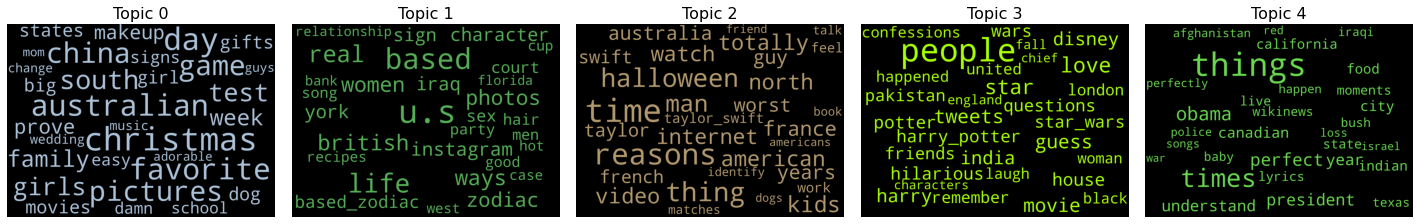

In [ ]:
plotTopicWordClouds(nostopModel5, 5, 1, 5)

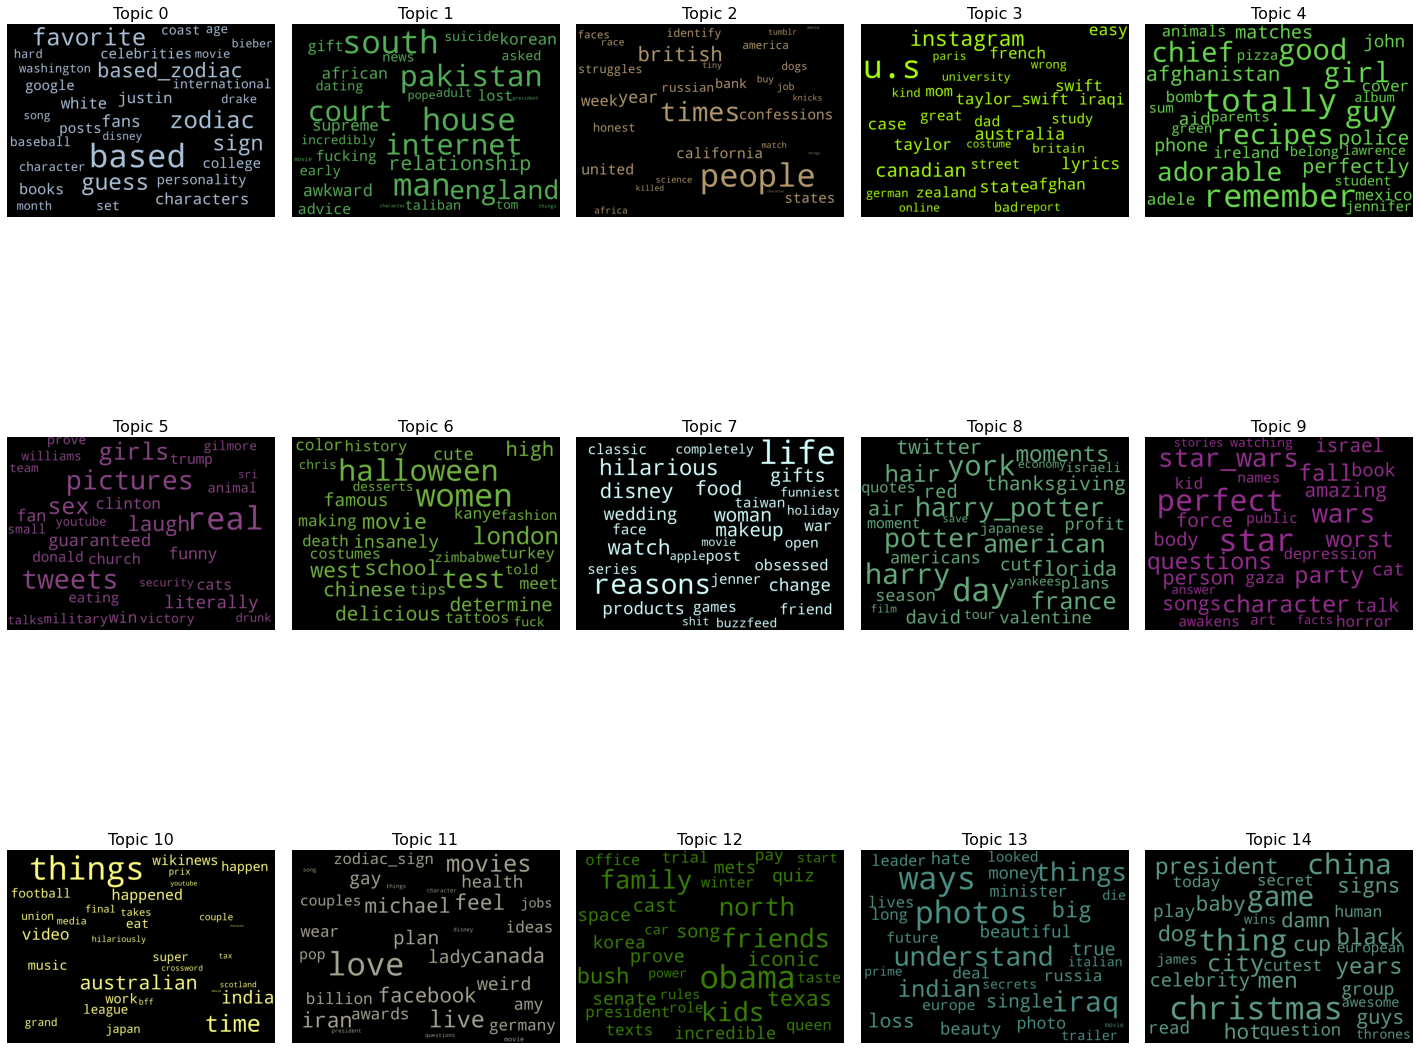

In [ ]:
plotTopicWordClouds(nostopModel15, 15, 3, 5)

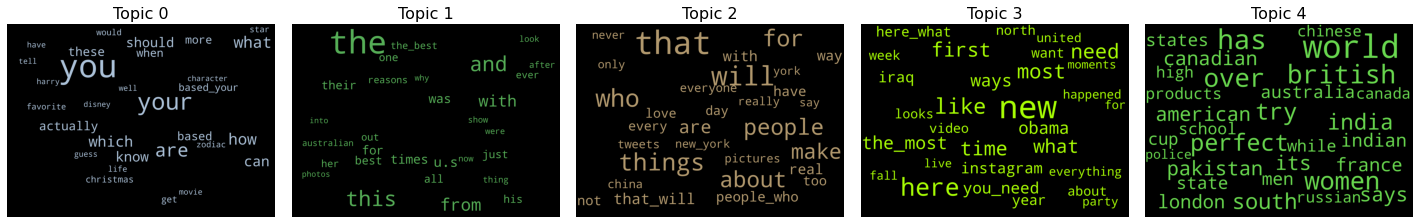

In [ ]:
plotTopicWordClouds(stopModel5, 5, 1, 5)

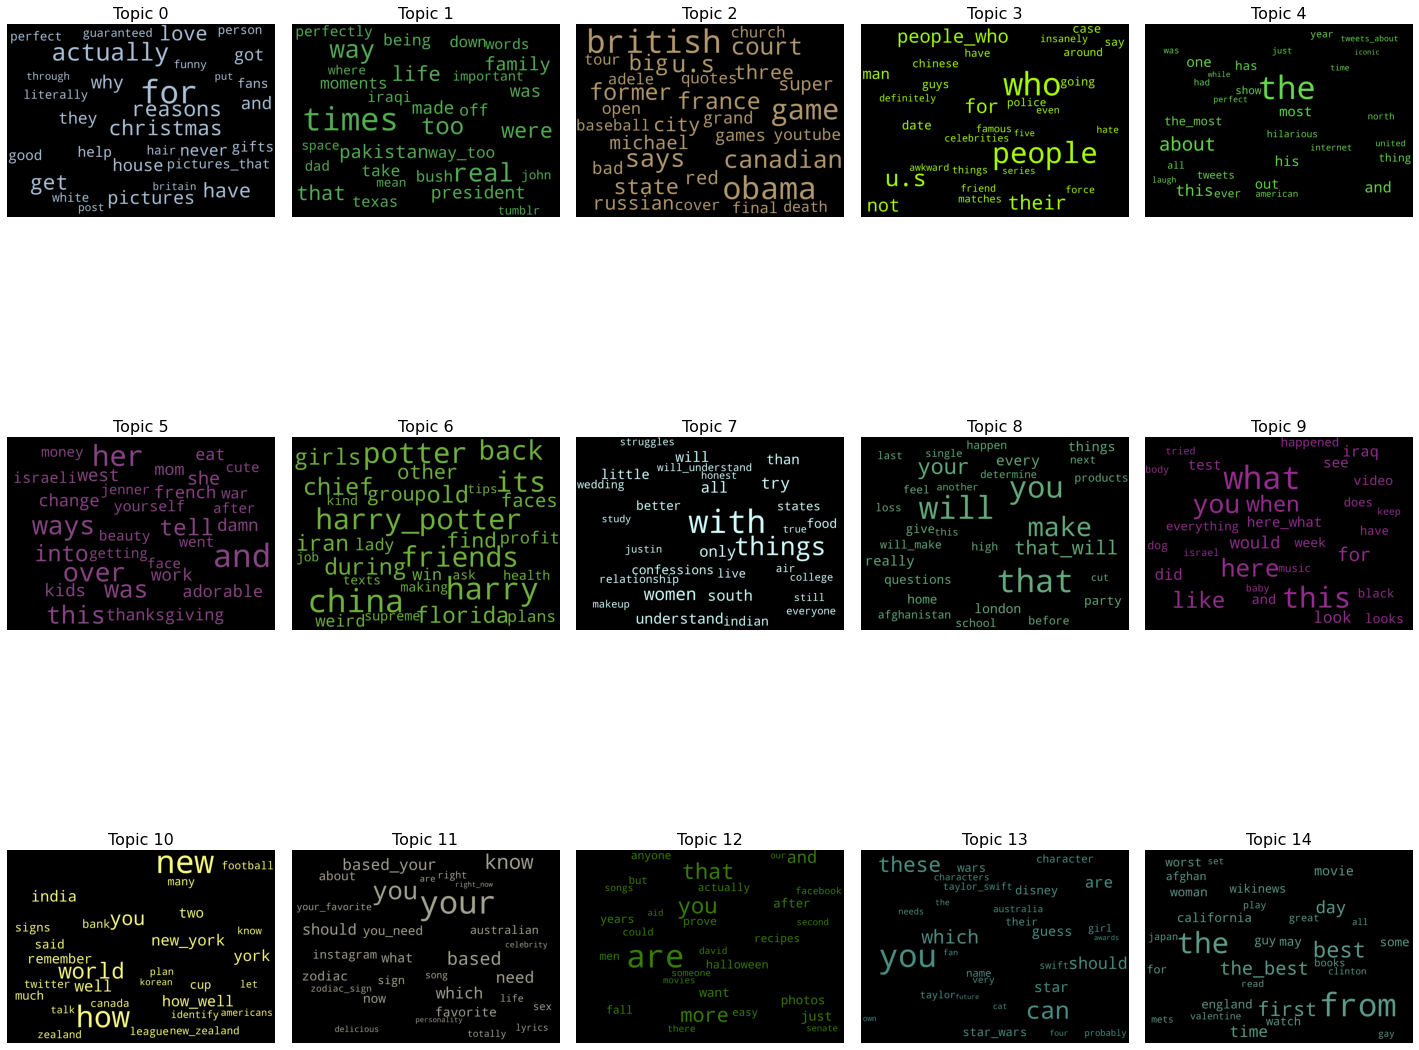

In [ ]:
plotTopicWordClouds(stopModel15, 15, 3, 5)

> # 5 Data Exploration

In [ ]:
# compare [' the ', ' The ', ' of ', ' Of ', ' to ', ' To ']
c0 = 0
c1 = 0

for text, label in zip(df_train['text'], df_train['class']): 
    if " In " in text:
        if label == 0:
            c0 += 1
        if label == 1:
            c1 += 1

print("non-clickbait:", c0)
print("clickbait:", c1)       

non-clickbait: 9
clickbait: 1118
